In [19]:
import pandas as pd
import numpy as np
import uuid
import hashlib
import matplotlib.pyplot as plt

In [20]:
# Load Dataset
df = pd.read_csv("./data/healthcare_dataset.csv")
print("Dataset loaded successfully")
print("Shape:", df.shape)
print(df.head())

Dataset loaded successfully
Shape: (55500, 15)
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Disch

# Identifying Attributes

**EI (Explicit Identifiers)**
Name, Doctor, Room Number

**QI (Quasi-identifiers)**
Age, Gender, Blood Type, Hospital, Insurance Provider, Admission Type, Date of Admission

**SA (Sensitive Attributes)**
Medical Condition, Test Results

In [21]:
# Remove or Tokenize Explicit Identifiers
df = df.drop(columns=["Name", "Doctor", "Room Number"], errors="ignore")
df["AnonID"] = [str(uuid.uuid4()) for _ in range(len(df))]

In [22]:
# Generalize Quasi-Identifiers

# Age -> range bins
bins = [0, 18, 30, 40, 50, 60, 70, 100]
labels = ["0-17", "18-29", "30-39", "40-49", "50-59", "60-69", "70+"]
df["AgeRange"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False).astype(str)
df = df.drop(columns=["Age"], errors="ignore")

# Insurance Provider -> first word
df["InsuranceGroup"] = df["Insurance Provider"].astype(str).str.split().str[0]
df = df.drop(columns=["Insurance Provider"], errors="ignore")

# Hospital -> first word
df["HospitalGroup"] = df["Hospital"].astype(str).str.split().str[0]
df = df.drop(columns=["Hospital"], errors="ignore")

# Date of Admission -> Year-Month
df["AdmYM"] = pd.to_datetime(df["Date of Admission"], errors="coerce").dt.to_period("M").astype(str)
df = df.drop(columns=["Date of Admission"], errors="ignore")

In [23]:
# k- and l-Anonymization Functions

def apply_k_l_anonymity(df, qi_cols, sensitive_col, k=3, l=2):
    """Apply k-anonymity and l-diversity, returning df, risk, info_loss."""
    group_sizes = df.groupby(qi_cols).size().reset_index(name="count")
    df_k = df.merge(group_sizes, on=qi_cols, how="left")
    df_k = df_k[df_k["count"] >= k].copy()
    diversity = df_k.groupby(qi_cols)[sensitive_col].nunique().reset_index(name="distinct_sa")
    good_classes = diversity[diversity["distinct_sa"] >= l]
    df_l = df_k.merge(good_classes[qi_cols], on=qi_cols, how="inner")
    risk = round(1 / k, 2)
    before_unique = df[qi_cols].drop_duplicates().shape[0]
    after_unique = df_l[qi_cols].drop_duplicates().shape[0]
    info_loss = round(1 - (after_unique / before_unique), 4)
    return df_l, risk, info_loss

In [24]:
# Tokenization vs Encryption/Masking

def tokenize(v):
    return str(uuid.uuid4())[:8]

def encrypt_sha256(v):
    if pd.isna(v): return v
    return hashlib.sha256(str(v).encode()).hexdigest()[:10]

def mask_value(v):
    if pd.isna(v): return v
    s = str(v)
    n = len(s)
    return s[0] + "*"*(n-2) + s[-1] if n>2 else "*"*n

def compare_protection_methods(df, column="AnonID"):
    methods = {
        "Tokenization": df[column].apply(tokenize),
        "Encryption": df[column].apply(encrypt_sha256),
        "Masking": df[column].apply(mask_value),
    }
    results = []
    for name, series in methods.items():
        results.append({
            "Method": name,
            "Unique_Ratio": round(series.nunique()/len(series),3),
            "Avg_Length": round(series.astype(str).apply(len).mean(),1),
            "Reversible": "Yes (vault)" if name=="Tokenization" else "No"
        })
    comp = pd.DataFrame(results)
    print("Tokenization vs Encryption/Masking")
    print(comp)
    return comp

In [25]:
# Visualizations
def evaluate_k_l_sweep(df, qi_cols, sensitive_col, k_values=[2,3,4,5], l_values=[1,2,3]):
    records = []
    for k in k_values:
        for l in l_values:
            df_l, risk, info_loss = apply_k_l_anonymity(df, qi_cols, sensitive_col, k, l)
            records.append({
                "k": k, "l": l,
                "risk": risk,
                "info_loss(%)": info_loss*100,
                "records_retained": len(df_l)
            })
    res = pd.DataFrame(records)
    print("Anonymization metrics:")
    print(res)

    # Info loss vs k
    plt.figure(figsize=(7,5))
    for l in l_values:
        s = res[res["l"]==l]
        plt.plot(s["k"], s["info_loss(%)"], marker="o", label=f"l={l}")
    plt.title("Information Loss vs k")
    plt.xlabel("k")
    plt.ylabel("Information Loss (%)")
    plt.legend(); plt.grid(True); plt.show()

    # Risk vs k
    plt.figure(figsize=(7,5))
    for l in l_values:
        s = res[res["l"]==l]
        plt.plot(s["k"], s["risk"], marker="s", label=f"l={l}")
    plt.title("Re-identification Risk vs k")
    plt.xlabel("k"); plt.ylabel("Risk (1/k)")
    plt.legend(); plt.grid(True); plt.show()

    # Records retained vs k
    plt.figure(figsize=(7,5))
    for l in l_values:
        s = res[res["l"]==l]
        plt.plot(s["k"], s["records_retained"], marker="^", label=f"l={l}")
    plt.title("Records Retained vs k")
    plt.xlabel("k"); plt.ylabel("Records Retained")
    plt.legend(); plt.grid(True); plt.show()
    return res

k-Anonymity(l-Diversity) applied (k=3, l=2)
Re-identification risk ≈ 0.33
Information loss ≈ 8.91%
Records retained: 55427
saved anonymised dataset
Tokenization vs Encryption/Masking
         Method  Unique_Ratio  Avg_Length   Reversible
0  Tokenization         1.000         8.0  Yes (vault)
1    Encryption         1.000        10.0           No
2       Masking         0.005        36.0           No
Anonymization metrics:
    k  l  risk  info_loss(%)  records_retained
0   2  1  0.50          4.27             55477
1   2  2  0.50          5.57             55463
2   2  3  0.50          9.46             55417
3   3  1  0.33          8.91             55427
4   3  2  0.33          8.91             55427
5   3  3  0.33          9.46             55417
6   4  1  0.25          9.83             55412
7   4  2  0.25          9.83             55412
8   4  3  0.25         10.02             55408
9   5  1  0.20         10.39             55400
10  5  2  0.20         10.39             55400
11  5  3  

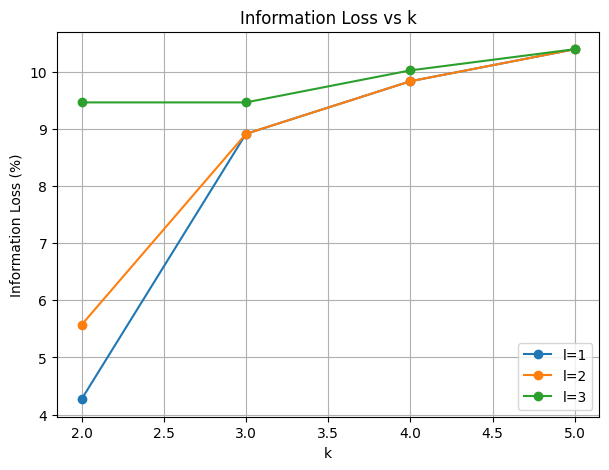

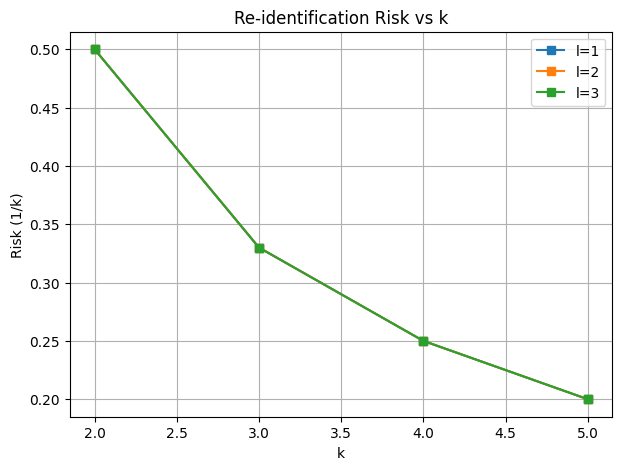

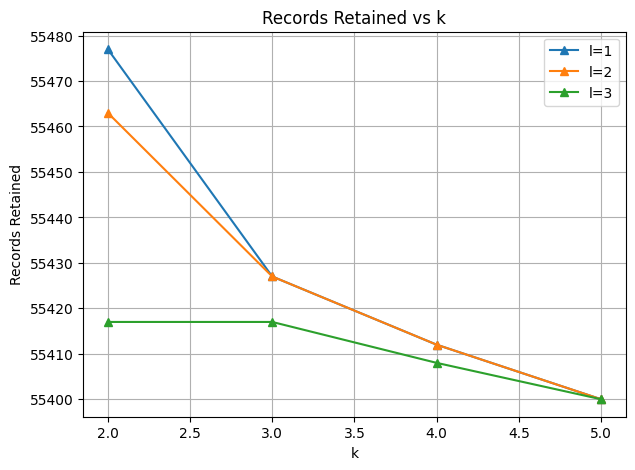

outputs and visualizations generated


In [26]:
# Run the analysis pipeline
qi_cols = ["AgeRange", "Gender", "Blood Type", "InsuranceGroup"]
sensitive_col = "Medical Condition"

# Apply base k-l anonymization (k=3, l=2)
df_l, risk, info_loss = apply_k_l_anonymity(df, qi_cols, sensitive_col, k=3, l=2)
print(f"k-Anonymity(l-Diversity) applied (k=3, l=2)")
print(f"Re-identification risk ≈ {risk}")
print(f"Information loss ≈ {info_loss*100:.2f}%")
print("Records retained:", len(df_l))

df_l.to_csv("anonymised_dataset.csv", index=False)
print("saved anonymised dataset")

# Compare Tokenization vs Encryption/Masking
method_comp = compare_protection_methods(df)

# Evaluate multiple (k,l) combinations
metrics_df = evaluate_k_l_sweep(df, qi_cols, sensitive_col)

# Save all metrics
method_comp.to_csv("method_comparison.csv", index=False)
metrics_df.to_csv("kl_metrics.csv", index=False)
print("outputs and visualizations generated")


In [27]:
# Evaluate Metrics: Before vs After Anonymization

def evaluate_metrics_before_after(df_original, df_anonymised, qi_cols, sensitive_col, k):
    metrics = {}

    # --- Before Anonymization ---
    metrics["before_records"] = len(df_original)
    metrics["before_unique_qi"] = df_original[qi_cols].drop_duplicates().shape[0]
    metrics["before_sa_unique"] = df_original[sensitive_col].nunique()
    metrics["before_risk"] = 1.0  # each record is unique, so risk = 100%
    metrics["before_info_loss"] = 0.0

    # --- After Anonymization ---
    metrics["after_records"] = len(df_anonymised)
    metrics["after_unique_qi"] = df_anonymised[qi_cols].drop_duplicates().shape[0]
    metrics["after_sa_unique"] = df_anonymised[sensitive_col].nunique()
    metrics["after_risk"] = round(1 / k, 2)
    metrics["after_info_loss"] = round(1 - (metrics["after_unique_qi"] / metrics["before_unique_qi"]), 4)

    # --- Derived Metrics ---
    metrics["record_retention(%)"] = round((metrics["after_records"] / metrics["before_records"]) * 100, 2)
    metrics["diversity_retention(%)"] = round((metrics["after_sa_unique"] / metrics["before_sa_unique"]) * 100, 2)

    comparison = pd.DataFrame({
        "Metric": [
            "Total Records",
            "Unique QI combinations",
            "Unique Sensitive Values",
            "Re-identification Risk",
            "Information Loss (%)",
            "Record Retention (%)",
            "Diversity Retention (%)"
        ],
        "Before": [
            metrics["before_records"],
            metrics["before_unique_qi"],
            metrics["before_sa_unique"],
            metrics["before_risk"],
            metrics["before_info_loss"] * 100,
            100,
            100
        ],
        "After": [
            metrics["after_records"],
            metrics["after_unique_qi"],
            metrics["after_sa_unique"],
            metrics["after_risk"],
            metrics["after_info_loss"] * 100,
            metrics["record_retention(%)"],
            metrics["diversity_retention(%)"]
        ]
    })

    print("Before vs After Anonymization Metrics:")
    print(comparison)
    return comparison

metrics_comparison = evaluate_metrics_before_after(df, df_l, qi_cols, sensitive_col, k=3)
metrics_comparison.to_csv("before_after_metrics.csv", index=False)
print("Saved metrics comparison as before_after_metrics.csv")


Before vs After Anonymization Metrics:
                    Metric   Before     After
0            Total Records  55500.0  55427.00
1   Unique QI combinations    539.0    491.00
2  Unique Sensitive Values      6.0      6.00
3   Re-identification Risk      1.0      0.33
4     Information Loss (%)      0.0      8.91
5     Record Retention (%)    100.0     99.87
6  Diversity Retention (%)    100.0    100.00
Saved metrics comparison as before_after_metrics.csv
